# AI 2, Walid OUBRAIM
## Glioma Grading: Clinical and Mutation Features
The task is to design Artificial Neural Network classifier to predict Glioma grade using the provided dataset

### Data and Preprocessing

In [253]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset = pd.read_csv('TCGA_GBM_LGG_Mutations_all.csv')

In [254]:
dataset.head()

,sample_id,Grade,Gender,Age_at_diagnosis,Race,IDH1,TP53,ATRX,PTEN,EGFR,...,FUBP1,RB1,NOTCH1,BCOR,CSMD3,SMARCA4,GRIN2A,IDH2,FAT4,PDGFRA
0,1,LGG,Male,51 years 108 days,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
1,2,LGG,Male,38 years 261 days,white,MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
2,3,LGG,Male,35 years 62 days,white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED
3,4,LGG,Female,32 years 283 days,white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,MUTATED,NOT_MUTATED
4,5,LGG,Male,31 years 187 days,white,MUTATED,MUTATED,MUTATED,NOT_MUTATED,NOT_MUTATED,...,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED,NOT_MUTATED


In [255]:
# Representing the dimensionality of the DataFrame
print("Rows, Columns :",dataset.shape)

# Check if the dataset has null values
has_nan = dataset.isnull().values.any()
if has_nan:
    print("The dataset contains NaN values.")
else:
    print("The dataset does not contain any NaN values.")

# Display columns with number of null values
missing_values = dataset.isnull().sum()
print(missing_values)

Rows, Columns : (846, 25)
The dataset does not contain any NaN values.
sample_id           0
Grade               0
Gender              0
Age_at_diagnosis    0
Race                0
IDH1                0
TP53                0
ATRX                0
PTEN                0
EGFR                0
CIC                 0
MUC16               0
PIK3CA              0
NF1                 0
PIK3R1              0
FUBP1               0
RB1                 0
NOTCH1              0
BCOR                0
CSMD3               0
SMARCA4             0
GRIN2A              0
IDH2                0
FAT4                0
PDGFRA              0
dtype: int64


In [256]:
# Display unique values to see if there is some 'special' values
for column in dataset.columns:
    print(f"{column}: {dataset[column].unique()}")

sample_id: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244

We can see that :
- The columns "Gender", "Age_at_diagnosis" and "Race" has '--' values
- The column Race has 'not reported' values
- The column "Age_at_diagnosis" has a value without 'days'

To deal with 'empty' values ('--', 'not reported'), we can either remove the rows or/and do imputation (impute missing values with the most frequent value).
We will also create a function to transform the Age_at_diagnosis column into numericals values.

In [257]:
# Extract the numerical value from the age column
def extract_age(age):
    if 'years' in age and 'days' in age:
        splitting = age.split(' ')
        years = int(splitting[0])
        days = int(splitting[2])
        return years + days/365
    elif 'years' in age:
        years = int(age.split(' ')[0])
        return years
    else:
        return None

# Drop rows that contain '--' for Gender and Age
dataset = dataset.drop(dataset[dataset['Gender'] == '--'].index)
dataset = dataset.drop(dataset[dataset['Age_at_diagnosis'] == '--'].index)
# Apply the function on the Age column
dataset['Age_at_diagnosis'] = dataset['Age_at_diagnosis'].apply(extract_age)

# Impute "not reported" values with the most frequent value
dataset['Race'] = dataset['Race'].replace('not reported',np.nan)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
dataset[['Race']] = imputer.fit_transform(dataset[['Race']])

<ipython-input-258-74ba3d80aca7>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender', data=dataset, palette='Set1')
<ipython-input-258-74ba3d80aca7>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Race', data=dataset, palette='Set1')
<ipython-input-258-74ba3d80aca7>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Grade', data=dataset, palette='Set1')


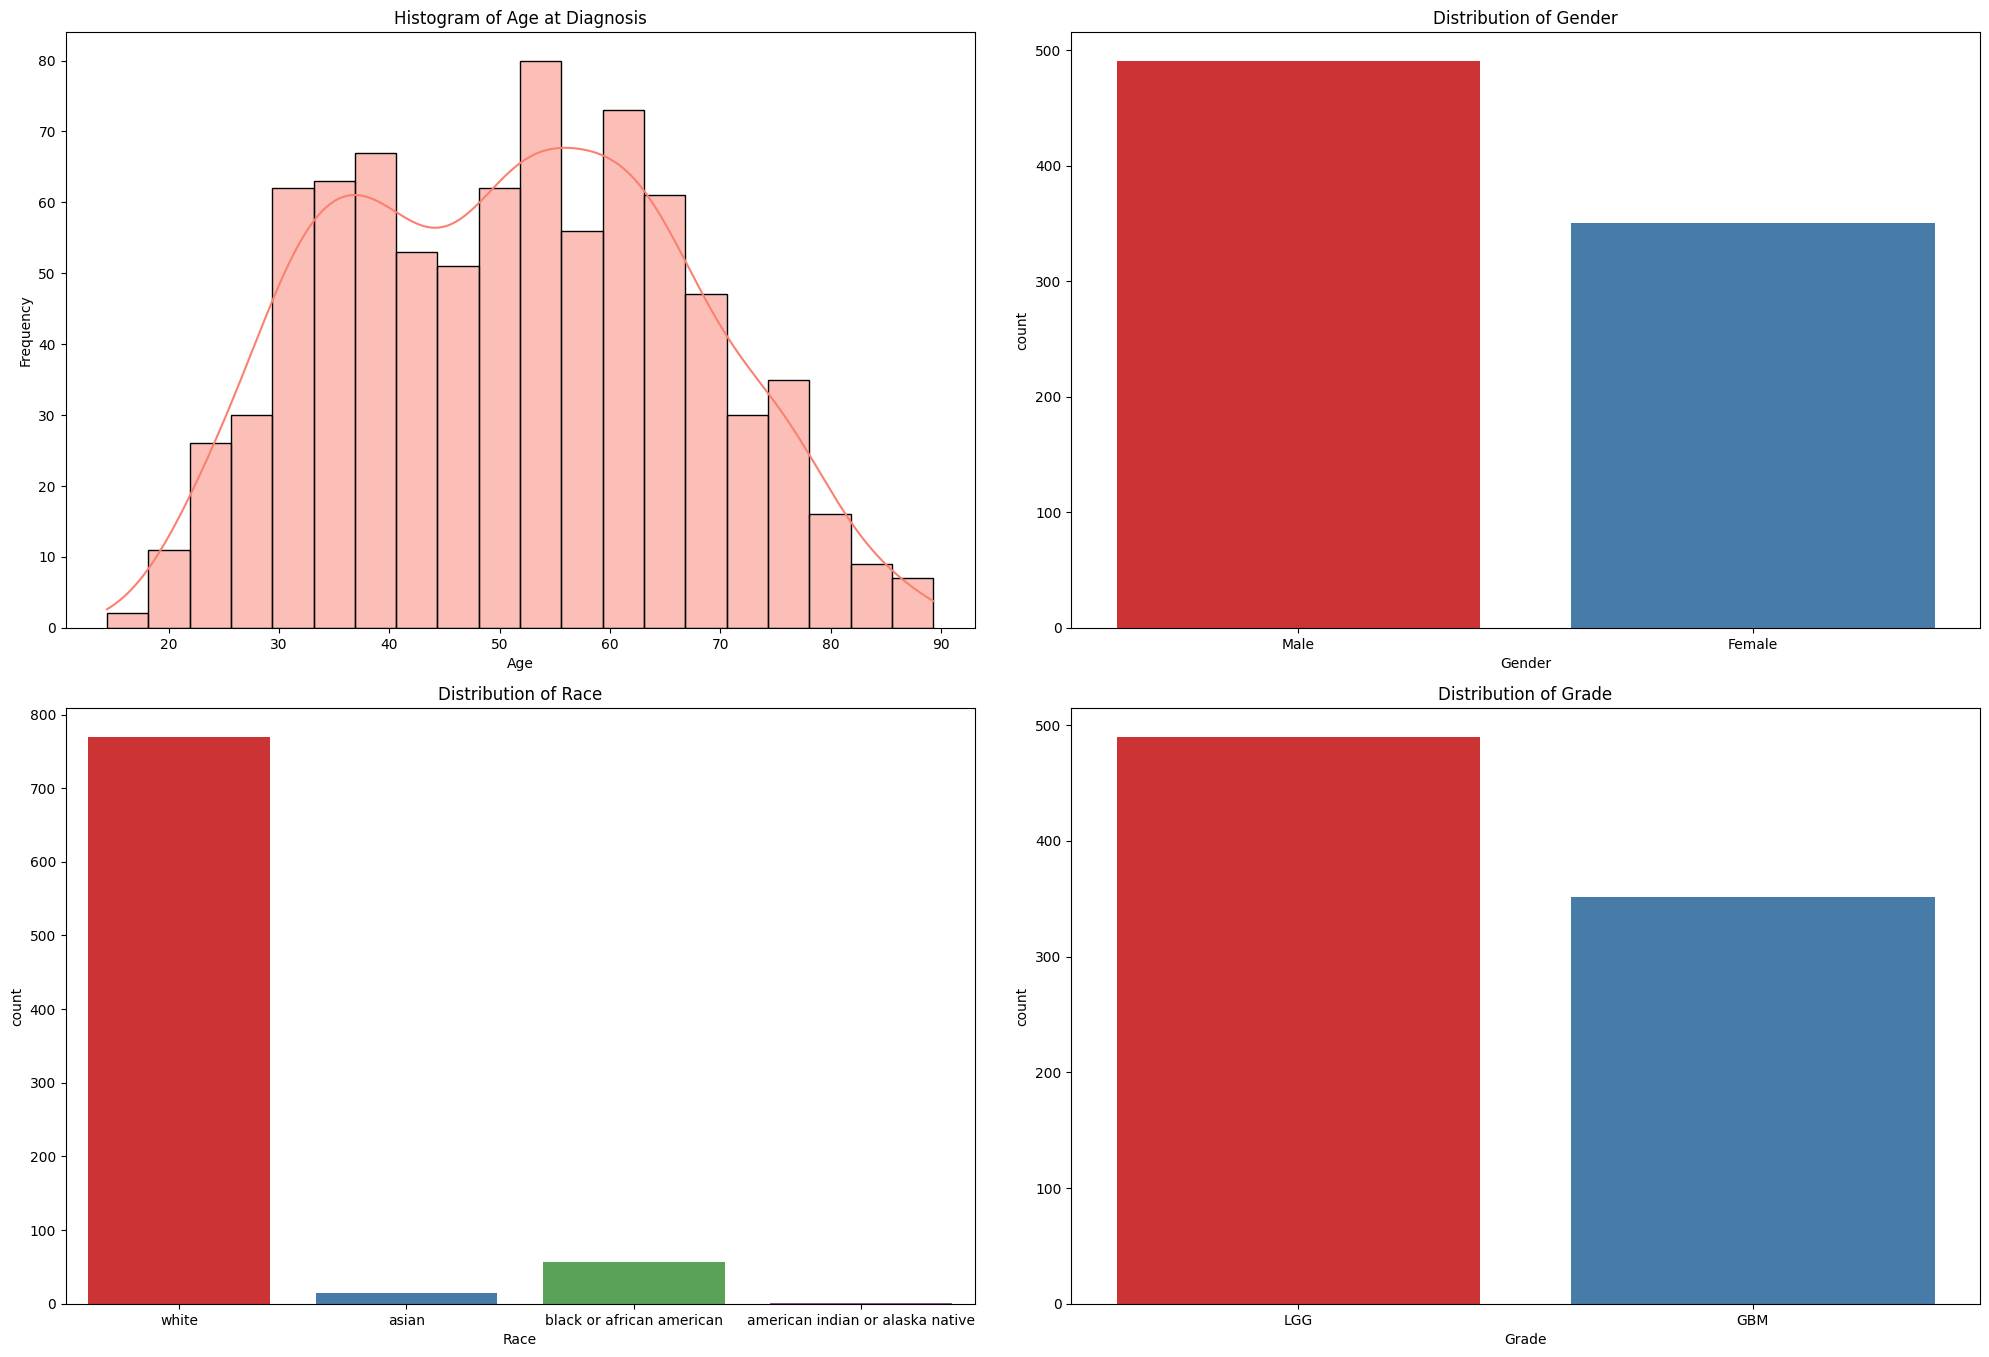

In [258]:
import seaborn as sns

plt.figure(figsize=(20, 20))

plt.subplot(3, 2, 1)
sns.histplot(dataset['Age_at_diagnosis'], bins=20, kde=True, color='salmon')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age at Diagnosis')

plt.subplot(3, 2, 2)
sns.countplot(x='Gender', data=dataset, palette='Set1')
plt.xlabel('Gender')
plt.xlabel('Gender')
plt.title('Distribution of Gender')

plt.subplot(3, 2, 3)
sns.countplot(x='Race', data=dataset, palette='Set1')
plt.xlabel('Race')
plt.title('Distribution of Race')

plt.subplot(3, 2, 4)
sns.countplot(x='Grade', data=dataset, palette='Set1')
plt.xlabel('Grade')
plt.title('Distribution of Grade')


plt.tight_layout()
plt.show()

The dependant variable is : ['Grade']
The categorials columns are :  the 20 genes, ['Gender'], ['Race']
The continious columns are : ['Age_at_diagnosis']

In [259]:
# Independant variable
X = dataset.iloc[:, 2:-1].values
print(X)
# Dependant variable
y = dataset.iloc[:, 1].values
#print(y)

[['Male' 51.295890410958904 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ['Male' 38.71506849315068 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ['Male' 35.16986301369863 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ...
 ['Female' 77.4876712328767 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ['Male' 63.33150684931507 'white' ... 'NOT_MUTATED' 'NOT_MUTATED'
  'NOT_MUTATED']
 ['Male' 76.6054794520548 'black or african american' ... 'NOT_MUTATED'
  'NOT_MUTATED' 'NOT_MUTATED']]


In [260]:
# Encoding the Dependent Variable
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()

In [261]:
# Encoding the Independent Variable with OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
print(X[0])


[0.0 1.0 0.0 0.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0
 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 1.0 0.0 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0
 0.0 1.0 0.0 1.0 0.0 1.0 0.0 1.0 51.295890410958904]


### Data Splitting

In [262]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(X_train)
#print(y_train)
#print(X_test)
#print(y_test)

[[0.0 1.0 0.0 ... 0.0 1.0 35.16986301369863]
 [0.0 1.0 0.0 ... 0.0 1.0 61.30684931506849]
 [1.0 0.0 0.0 ... 0.0 1.0 44.57260273972603]
 ...
 [0.0 1.0 0.0 ... 0.0 1.0 78.25479452054795]
 [1.0 0.0 0.0 ... 0.0 1.0 52.652054794520545]
 [0.0 1.0 0.0 ... 0.0 1.0 48.5013698630137]]


### Apply feature scaling

In [263]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
print(X_train)
print(X_test)

[[-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
  -0.97665231]
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
   0.69156567]
 [ 1.16528741 -1.16528741 -0.03860457 ... -0.15109947  0.15109947
  -0.37651351]
 ...
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
   1.77328437]
 [ 1.16528741 -1.16528741 -0.03860457 ... -0.15109947  0.15109947
   0.13916519]
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
  -0.12575622]]
[[-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
   0.26751655]
 [-0.85815739  0.85815739 -0.03860457 ...  6.61815684 -6.61815684
  -0.62499755]
 [ 1.16528741 -1.16528741 -0.03860457 ... -0.15109947  0.15109947
  -0.12593109]
 ...
 [ 1.16528741 -1.16528741 -0.03860457 ... -0.15109947  0.15109947
   1.19657757]
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
   0.35494936]
 [-0.85815739  0.85815739 -0.03860457 ... -0.15109947  0.15109947
  -0.43159618]]


### Build ANN classifier using Keras


In [265]:
import keras
from keras import layers

# Build the model (sequential)

input = X_train.shape[1]

num_output = len(np.unique(y))


model = keras.Sequential(
    [
        keras.Input(shape=input),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_output, activation="softmax"),
    ]
)
model.summary()

45
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               11776     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 2)                 130       
                                                                 
Total params: 28354 (110.76 KB)
Trainable params: 28354 (110.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train and model fitting

In [266]:
batch_size = 64
epochs = 25

# Callbacks

callbacks=[keras.callbacks.EarlyStopping(patience=10),
           keras.callbacks.ModelCheckpoint("mnist_model.h5", save_best_only=True)]


# step 1 compilation
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# step 2 model fitting

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.25, callbacks = callbacks)

Epoch 1/25
8/8 [==============================] - 1s 34ms/step - loss: 0.8032 - accuracy: 0.5238 - val_loss: 0.5188 - val_accuracy: 0.7143
Epoch 2/25
8/8 [==============================] - 0s 12ms/step - loss: 0.5901 - accuracy: 0.7103 - val_loss: 0.4131 - val_accuracy: 0.8750
Epoch 3/25
8/8 [==============================] - 0s 10ms/step - loss: 0.5147 - accuracy: 0.7976 - val_loss: 0.3719 - val_accuracy: 0.8631


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/25
8/8 [==============================] - 0s 10ms/step - loss: 0.4475 - accuracy: 0.8234 - val_loss: 0.3476 - val_accuracy: 0.8690
Epoch 5/25
8/8 [==============================] - 0s 9ms/step - loss: 0.3889 - accuracy: 0.8552 - val_loss: 0.3320 - val_accuracy: 0.8690
Epoch 6/25
8/8 [==============================] - 0s 12ms/step - loss: 0.4085 - accuracy: 0.8492 - val_loss: 0.3261 - val_accuracy: 0.8690
Epoch 7/25
8/8 [==============================] - 0s 11ms/step - loss: 0.3784 - accuracy: 0.8492 - val_loss: 0.3215 - val_accuracy: 0.8750
Epoch 8/25
8/8 [==============================] - 0s 7ms/step - loss: 0.3749 - accuracy: 0.8472 - val_loss: 0.3215 - val_accuracy: 0.8750
Epoch 9/25
8/8 [==============================] - 0s 8ms/step - loss: 0.3576 - accuracy: 0.8591 - val_loss: 0.3216 - val_accuracy: 0.8750
Epoch 10/25
8/8 [==============================] - 0s 11ms/step - loss: 0.3512 - accuracy: 0.8730 - val_loss: 0.3200 - val_accuracy: 0.8810
Epoch 11/25
8/8 [============

### Predicting the Test set results

In [267]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.3409 - accuracy: 0.8580


[0.34085357189178467, 0.857988178730011]

### Using Keras Tuner

In [269]:
import keras_tuner as kt

import keras
import keras_tuner as kt
from keras import layers

# Define the model builder function
def model_builder(hp):
    input_shape = X_train.shape[1]
    num_classes = len(np.unique(y_train))

    input = layers.Input(shape=input_shape)
    x = layers.Dense(hp.Int('units_1', min_value=32, max_value=512, step=32), activation="relu")(input)
    x = layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_2', min_value=32, max_value=512, step=32), activation="relu")(x)
    x = layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1))(x)
    output = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.models.Model(input, output)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=3)




Reloading Tuner from ./untitled_project/tuner0.json


In [270]:
# Perform the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_split=0.25)

best_model = tuner.get_best_models()[0]
best_model.summary()

# Get the best hyperparameters


best_params = tuner.get_best_hyperparameters()[0].values
print(best_params)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 45)]              0         
                                                                 
 dense (Dense)               (None, 288)               13248     
                                                                 
 dropout (Dropout)           (None, 288)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               73984     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 87746 (342.76 KB)
Trainable params: 87746 (342.

The best parameters are :
*   units_1 : 288
*   dropout_1 : 0.3
*   units_2 : 256
*   dropout_2 : 0.3







In [271]:
# Build the best model

model2 = keras.Sequential(
    [
        keras.Input(shape=X_train.shape[1]),
        layers.Dense(288, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_output, activation="softmax"),
    ]
)
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 288)               13248     
                                                                 
 dropout_2 (Dropout)         (None, 288)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               73984     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 87746 (342.76 KB)
Trainable params: 87746 (342.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [272]:
# step 1 compilation
model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# step 2 model fitting

history = model2.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.25, callbacks = callbacks)


Epoch 1/25
8/8 [==============================] - 3s 29ms/step - loss: 0.6102 - accuracy: 0.6925 - val_loss: 0.3726 - val_accuracy: 0.8512
Epoch 2/25
8/8 [==============================] - 0s 8ms/step - loss: 0.4077 - accuracy: 0.8591 - val_loss: 0.3346 - val_accuracy: 0.8750
Epoch 3/25
8/8 [==============================] - 0s 9ms/step - loss: 0.3473 - accuracy: 0.8790 - val_loss: 0.3151 - val_accuracy: 0.8810
Epoch 4/25
8/8 [==============================] - 0s 7ms/step - loss: 0.3129 - accuracy: 0.8810 - val_loss: 0.3188 - val_accuracy: 0.8988
Epoch 5/25
8/8 [==============================] - 0s 7ms/step - loss: 0.2939 - accuracy: 0.8810 - val_loss: 0.3298 - val_accuracy: 0.8869
Epoch 6/25
8/8 [==============================] - 0s 7ms/step - loss: 0.3014 - accuracy: 0.8810 - val_loss: 0.3207 - val_accuracy: 0.8690
Epoch 7/25
8/8 [==============================] - 0s 10ms/step - loss: 0.2959 - accuracy: 0.8810 - val_loss: 0.3076 - val_accuracy: 0.8750
Epoch 8/25
8/8 [================

Predicting with best parameters

In [273]:
# step 3 : predicting

model2.evaluate(X_test, y_test)

6/6 [==============================] - 0s 6ms/step - loss: 0.3655 - accuracy: 0.8639


[0.365487664937973, 0.8639053106307983]